In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from dataLoaders import DataLoaders
import numpy as np
import torchvision

import matplotlib.pyplot as plt
import time
from pathlib import Path
from tqdm.notebook import trange, tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
# from torchvision import datasets, models, transforms
import itertools
# import pixiedust
import random
from torch.utils import data
# from itertools import tee
from datetime import datetime
from utils import NET_ARCHICECTURE
from enum import Enum
from trainer import Trainer
from training_params import TrainingParams

from model import get_model

print("Torch Version: ", torch.__version__)
print("Cuda available?", torch.cuda.is_available())
if not torch.cuda.is_available():
    print("No GPU!")
    raise SystemExit("Stop right there!")

Torch Version:  1.7.1+cu110
Cuda available? True


In [3]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    LABS_DIR = Path ('/content/gdrive/My Drive/Labs')
except:
    LABS_DIR = Path ('C:/Labs/')

#DATA_DIR = LABS_DIR/'Data'    
DATA_DIR = LABS_DIR/'DataNoDuplicates'
#DATA_DIR = LABS_DIR/ 'DataDomains_v1'
DATA_DIR_M = LABS_DIR/'DataTraining'/'Male'
DATA_DIR_F = LABS_DIR/'DataTraining'/'Female'


In [4]:
#### sanity check for the images 
# classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
# for emotion in classes:
#     print("Class =",emotion)
#     !ls $DATA_DIR\VAL\$emotion | wc -l

# Data Loader

In [5]:
BATCH_SIZE = 64
SAMPLE_SIZE = 3000 

dataloader_all = DataLoaders(sample_size=SAMPLE_SIZE, batch_size=BATCH_SIZE//2, data_dir=DATA_DIR, val_same_as_train=False)
dataloder_male = DataLoaders(sample_size=None, batch_size=BATCH_SIZE//2, data_dir=DATA_DIR_M, val_same_as_train=False)
dataloder_female = DataLoaders(sample_size=None, batch_size=BATCH_SIZE//2, data_dir=DATA_DIR_F, val_same_as_train=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)
print("Classes: ", dataloder_male.classes) 
print(f'Male Train image size: {dataloder_male.dataset_size["train"]}')
print(f'Male Validation image size: {dataloder_male.dataset_size["val"]}')
print(f'Female Train image size: {dataloder_female.dataset_size["train"]}')
print(f'Female Validation image size: {dataloder_female.dataset_size["val"]}')

device:  cuda:0
Classes:  ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
Male Train image size: 2819
Male Validation image size: 707
Female Train image size: 2954
Female Validation image size: 742


In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated  


# Show sample of the data for review


classes=tensor([5, 2, 4, 2, 5, 1, 2, 0, 4, 3, 4, 0, 4, 6, 2, 0, 3, 0, 6, 0, 4, 2, 5, 0,
        0, 0, 0, 0, 1, 3, 0, 3])


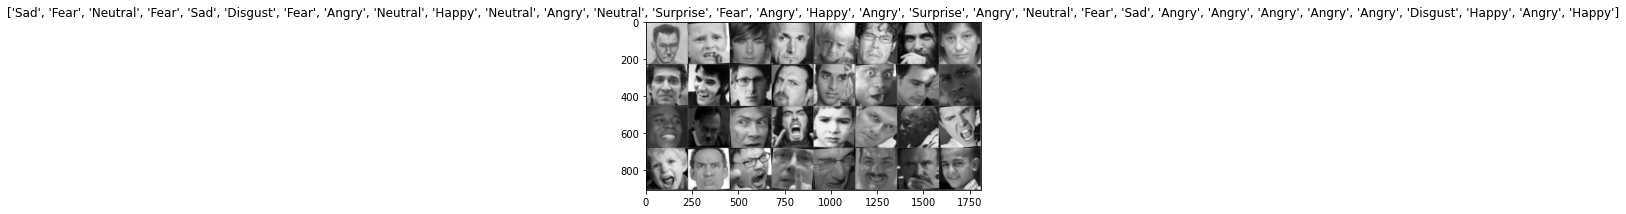

classes=tensor([5, 5, 3, 6, 6, 4, 0, 3, 6, 2, 0, 3, 4, 4, 6, 5, 2, 3, 2, 5, 5, 2, 5, 0,
        2, 5, 2, 2, 3, 2, 6, 3])


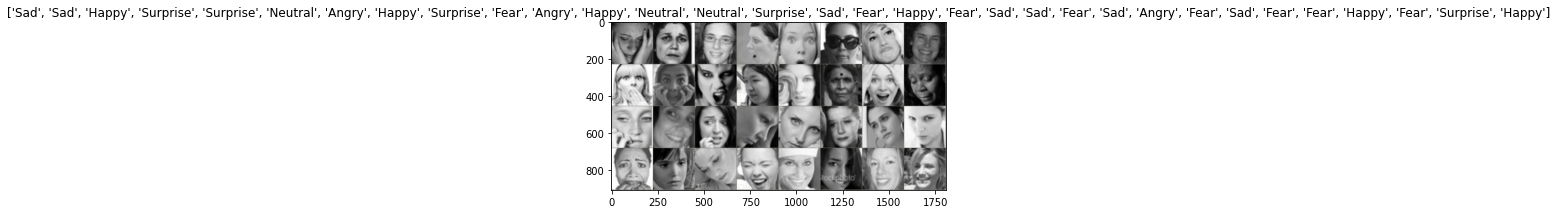

In [7]:
# # Get a batch of training data
class_names = dataloder_female.classes

inputs, classes = next(iter(dataloder_male.data['train']))
print()
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])


# # Get a batch of validation data
inputs, classes = next(iter(dataloder_female.data['val']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
#imshow(sample_train_images, title=classes)
print(f"classes={classes}")
imshow(sample_train_images, title=[class_names[i] for i in classes])

# Train Model

In [8]:
# CHECK_POINT_PATH = LABS_DIR/'ModelParams'/'checkpoint.tar'

# # !del $CHECK_POINT_PATH

# try:
#     checkpoint = torch.load(CHECK_POINT_PATH)
#     print("checkpoint loaded")
# except:
#     checkpoint = None
#     print("checkpoint not found")

In [9]:
NUM_EPOCHS = 30

def run_experiment(use_discriminator, experiment_title, domain1_dataloader,domain2_dataloader, test_dataloaders, training_params, architecure : NET_ARCHICECTURE, domain_loss_alpha=1):
    """
    Gets all hyper parameters and creates the relevant optimizer and scheduler according to those params

    """

    training_params.model = get_model(device,use_discriminator, domain1_dataloader.classes, architecure)
    
    descriminator_description = "D" if use_discriminator else "ND"
    experiment_name = datetime.now().strftime("%Y%m%d-%H%M%S") + "_"+ descriminator_description + str(training_params)
    print("Starting, experiment name: ", experiment_name)

    writer = SummaryWriter('runs/' + experiment_name)
    trainer = Trainer(device, domain1_dataloader, domain2_dataloader, BATCH_SIZE)
    
    trained_params_model = trainer.train_model(use_discriminator, training_params, domain_loss_alpha, writer=writer)
    
    print(f"Experiment {experiment_name} - testing on the women domain")
    test_acc = {experiment_title+loader_title : trainer.test(test_loader,trained_params_model) for loader_title,test_loader in test_dataloaders.items()}
    return trained_params_model, test_acc


# for lr in [0.001, 0.0005, 0.0001]:
#     for scheduler_step_size in [7]:
#         for scheduler_gamma in [0.3, 0.5]:
#             for weight_decay in [0.01,0.05,0.1]:
#                 model_conv = run_experiment(dataloder_male,dataloder_female, lr, scheduler_gamma, scheduler_step_size, weight_decay, NUM_EPOCHS,'fc_20+50_DO')


# training_params = TrainingParams(lr_initial=0.0001,step_size=7,gamma=0.5,weight_decay=0.01, num_epochs=NUM_EPOCHS)

for lr in [0.001,0.0003,0.0001,0.00003,0.00001]:
    for scheduler_gamma in [0.3,0.5]:
        for weight_decay in [0.01,0.05,0.1]:
            training_params = TrainingParams(lr_initial=lr,step_size=7,gamma=scheduler_gamma,weight_decay=weight_decay, num_epochs=NUM_EPOCHS)
            """ Train on both genders w\o discriminator and test spretley on the genders"""
            arch = NET_ARCHICECTURE.ONE_FC

            test_loaders = {"M" : dataloder_male,
                            "F" : dataloder_female}

            print("1st case: Train on both genders w\o discriminator and test separately on the genders")
            _,p1 = run_experiment(use_discriminator=False, experiment_title = "p1",\
                                   domain1_dataloader=dataloader_all,domain2_dataloader=dataloader_all,\
                                   test_dataloaders = test_loaders,training_params=training_params, architecure=arch)
            print(p1)
            print("Finished -----------------\r\n\r\n")

            print("2nd case: Train on one gender w\o discriminator and test separately on the genders")
            _,p2 = run_experiment(use_discriminator=False, experiment_title = "p2", \
                                   domain1_dataloader=dataloder_male,domain2_dataloader=dataloder_female, \
                                   test_dataloaders = test_loaders,training_params=training_params,architecure=arch)
            print(p2)
            print("Finished -----------------\r\n\r\n")

            print("3rd case: Train on one gender with discriminator and test separately on the genders")
            _,p3 = run_experiment(use_discriminator=True, experiment_title = "p3", \
                                   domain1_dataloader=dataloder_male,domain2_dataloader=dataloder_female, \
                                   test_dataloaders = test_loaders,training_params=training_params,architecure=arch,domain_loss_alpha=1 )
            print(p3)
            print("Finished -----------------\r\n\r\n")

# for alpha in [0, 16, 8, 4, 2, 1, 0.5,0.25,0.125,0.0625]:
#     print(f'3rd case: Train on one gender with discriminator and test separately on the genders, alpha={alpha}')
#     _,p3 = run_experiment(use_discriminator=True, experiment_title = "p3", \
#                            domain1_dataloader=dataloder_male,domain2_dataloader=dataloder_female, \
#                            test_dataloaders = test_loaders,training_params=training_params,architecure=arch, domain_loss_alpha=0)
#     print(f'alpha={alpha}')
#     print(p3)
#     print("Finished -----------------\r\n\r\n")




# print(f"p1(M): {p1M} p1(F): {p1F}")
# print(f"p2(M): {p2M} p2(F): {p2F}")
# print(f"p3(M): {p3M} p3(F): {p3F}")

# print(f"p1(M): {p1M} p1(F): {p1F} p2(M): {p2M} p2(F): {p2F} p3(M): {p3M} p3(F): {p3F}")
# trained_model_and_params, test_acc = run_experiment(use_discriminator=False, \
#                                           domain1_dataloader=dataloder_male,domain2_dataloader=dataloder_male, test_dataloader = dataloder_male,training_params=training_params)

# trained_model_and_params = run_experiment(dropout_layer=NET_ARCHICECTURE.TWO_FC, domain1_dataloader=dataloder_male,domain2_dataloader=dataloder_female, lr_initial=0.0001, gamma=0.5, step_size=7, weight_decay=0.01 , num_of_epochs=NUM_EPOCHS,experiment_note='final_tuning')
# trained_model_and_params = run_experiment(dropout_layer=NET_ARCHICECTURE.NO_FC, domain1_dataloader=dataloder_male,domain2_dataloader=dataloder_female, lr_initial=0.0001, gamma=0.5, step_size=7, weight_decay=0.1, num_of_epochs=NUM_EPOCHS,experiment_note='final_tuning')
# trained_model_and_params = run_experiment(dropout_layer=NET_ARCHICECTURE.ONE_FC, domain1_dataloader=dataloder_male,domain2_dataloader=dataloder_female, lr_initial=0.0001, gamma=0.5, step_size=7, weight_decay=0.1, num_of_epochs=NUM_EPOCHS,experiment_note='final_tuning')


1st case: Train on both genders w\o discriminator and test separately on the genders
Starting, experiment name:  20210120-012356_ND_lr_0.001_st_7_gma_0.3_wDK_0.01
Starting epochs
Epoch: 1 of 30
Test Loss: 1.6109 TestAcc: 0.3827 DescTestAcc: 0.0000
Epoch: 2 of 30


KeyboardInterrupt: 

# Test Model